In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import time

In [26]:
BATCH_SIZE = 64
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [27]:
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data',
train=True,
download=True,
transform=transform)
valid_dataset = datasets.MNIST(root='./data',
train=True,
transform=transform)
test_dataset = datasets.MNIST(root='./data',
train=False,
transform=transform)

In [28]:
validation_fraction = 0.1
num = int(validation_fraction * 60000)
train_indices = torch.arange(0, 60000 - num)
valid_indices = torch.arange(60000 - num, 60000)

In [29]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [30]:
train_loader = DataLoader(dataset=train_dataset,
batch_size=BATCH_SIZE,
drop_last=True,
sampler=train_sampler)
valid_loader = DataLoader(dataset=valid_dataset,
batch_size=BATCH_SIZE,
sampler=valid_sampler)
test_loader = DataLoader(dataset=test_dataset,
batch_size=BATCH_SIZE,
shuffle=False)

In [31]:
# Checking the dataset
for images, labels in train_loader:
  print('Image batch dimensions:', images.shape)
  print('Image label dimensions:', labels.shape)
  break

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


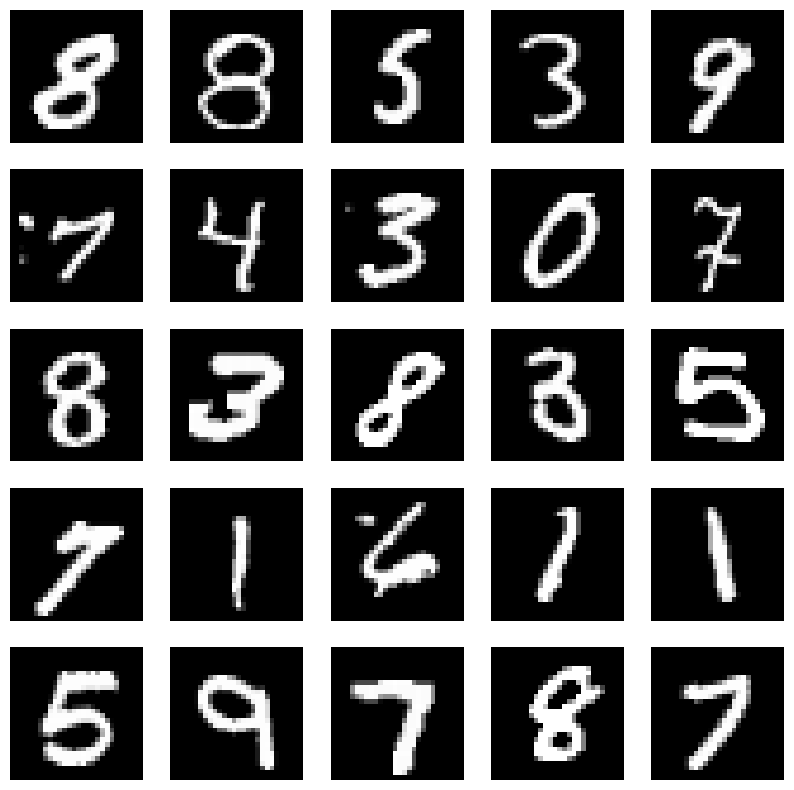

In [32]:
import matplotlib.pyplot as plt
# Display a grid of sample images
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(train_loader):
  for j in range(25):
    plt.subplot(5, 5, j + 1)
    plt.imshow(images[j].squeeze(), cmap='gray')
    plt.axis('off')
  break
plt.show()

In [33]:
class MLP(nn.Module):
  def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
    super().__init__()
    self.network = torch.nn.Sequential(
    # 1st hidden layer
    torch.nn.Flatten(),
    torch.nn.Linear(num_features, num_hidden_1),
    torch.nn.BatchNorm1d(num_hidden_1),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    # 2nd hidden layer
    torch.nn.Linear(num_hidden_1, num_hidden_2),
    torch.nn.BatchNorm1d(num_hidden_2),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    # output layer
    torch.nn.Linear(num_hidden_2, num_classes)
    )
  def forward(self, x):
    logits = self.network(x)
    return logits


In [34]:
model = MLP(num_features=28*28,
num_hidden_1=128,
num_hidden_2=64,
num_classes=10)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,
weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
factor=0.1,
mode='min')


In [35]:
# Define your optimizer (using Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [36]:
import torch.optim as optim
from torch.optim import lr_scheduler
# Create the scheduler with step decay
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [37]:
# Create the scheduler with exponential decay
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [38]:
def compute_accuracy(data_loader):
  with torch.no_grad():
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
      features = features.to(DEVICE)
      targets = targets.float().to(DEVICE)
      logits = model(features)
      _, predicted_labels = torch.max(logits, 1)
      num_examples += targets.size(0)
      correct_pred += (predicted_labels == targets).sum()
  return correct_pred.float()/num_examples * 100


In [39]:
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
for epoch in range(NUM_EPOCHS):

    model.train()

    for batch_idx, (features, targets) in enumerate(train_loader):

        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
# ## FORWARD AND BACK PROP
        logits = model(features)
#loss = F.cross_entropy(logits, targets)
        loss = criterion(logits, targets)
        optimizer.zero_grad()
        loss.backward()
# ## UPDATE MODEL PARAMETERS
        optimizer.step()
# ## LOGGING
        minibatch_loss_list.append(loss.item())
        logging_interval = 100
        if not batch_idx % logging_interval:
            print("Epoch: ", epoch+1,"/", NUM_EPOCHS,"| Batch ",batch_idx,
            "/",len(train_loader), f'| Loss: {loss:.4f}')
            model.eval()
            with torch.no_grad():# save memory during inference

                train_acc = compute_accuracy(train_loader)
                valid_acc = compute_accuracy(valid_loader)
                print("Epoch: ", epoch+1, "/",NUM_EPOCHS,
                f'| Train: {train_acc :.2f}% '
                f'| Validation: {valid_acc :.2f}%')
                train_acc_list.append(train_acc.item())
                valid_acc_list.append(valid_acc.item())
                elapsed = (time.time() - start_time)/60
                print("Time elapsed: ",elapsed, " min")
                scheduler.step(minibatch_loss_list[-1])
                elapsed = (time.time() - start_time)/60
                print(f'Total Training Time: {elapsed:.2f} min')
                test_acc = compute_accuracy(test_loader)
                print(f'Test accuracy {test_acc :.2f}%')

Epoch:  1 / 20 | Batch  0 / 843 | Loss: 2.3769
Epoch:  1 / 20 | Train: 8.86% | Validation: 8.45%
Time elapsed:  0.2692766507466634  min
Total Training Time: 0.27 min


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test accuracy 8.35%
Epoch:  1 / 20 | Batch  100 / 843 | Loss: 0.4620
Epoch:  1 / 20 | Train: 85.74% | Validation: 88.68%
Time elapsed:  0.6120911280314127  min
Total Training Time: 0.61 min
Test accuracy 86.58%
Epoch:  1 / 20 | Batch  200 / 843 | Loss: 0.5024
Epoch:  1 / 20 | Train: 88.73% | Validation: 91.05%
Time elapsed:  0.9604016621907552  min
Total Training Time: 0.96 min
Test accuracy 89.47%
Epoch:  1 / 20 | Batch  300 / 843 | Loss: 0.2413
Epoch:  1 / 20 | Train: 89.65% | Validation: 91.57%
Time elapsed:  1.3076606472333272  min
Total Training Time: 1.31 min
Test accuracy 90.50%
Epoch:  1 / 20 | Batch  400 / 843 | Loss: 0.2916
Epoch:  1 / 20 | Train: 90.52% | Validation: 92.23%
Time elapsed:  1.6545381585756938  min
Total Training Time: 1.65 min
Test accuracy 90.87%
Epoch:  1 / 20 | Batch  500 / 843 | Loss: 0.3557
Epoch:  1 / 20 | Train: 90.90% | Validation: 93.18%
Time elapsed:  2.0046987970670065  min
Total Training Time: 2.00 min
Test accuracy 91.39%
Epoch:  1 / 20 | Batch  6

Text(0, 0.5, 'Loss')

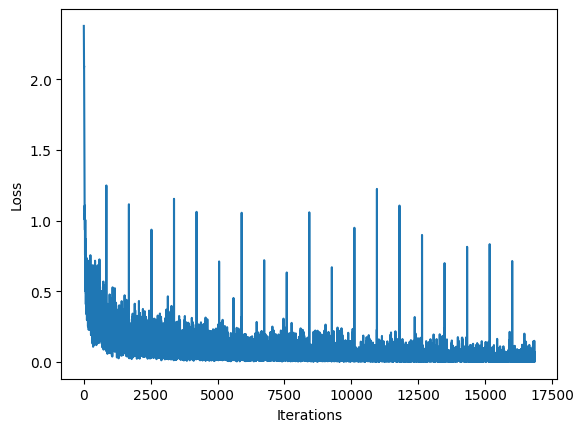

In [40]:
import matplotlib.pyplot as plt
plt.plot(range(len(minibatch_loss_list)), minibatch_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')

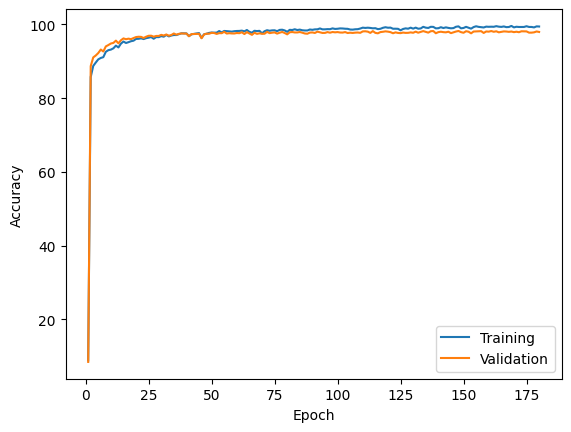

In [41]:
import numpy as np
num_epochs = len(train_acc_list)
plt.plot(np.arange(1, num_epochs+1),
train_acc_list, label='Training')
plt.plot(np.arange(1, num_epochs+1),
valid_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()